## Imports

In [1]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

## Data

In [2]:
gdf = gpd.read_file("../data/SANGIS/BUSINESS_SITES/BUSINESS_SITES.shp")

## Clustering Function

In [3]:

def clustering(import_df):
    import_df['x'] = import_df['geometry'].x
    import_df['y'] = import_df['geometry'].y

    hexes = matplotlib.pyplot.hexbin( x= import_df['x'], y=import_df['y'],mincnt=1,gridsize=3970)
    hexbins = gpd.points_from_xy(x=[i[0] for i in hexes.get_offsets()],y=[i[1] for i in hexes.get_offsets()])[1:]
    left_merge = gpd.GeoDataFrame(hexbins, geometry=0)
    full_merge = gpd.sjoin_nearest(left_merge,import_df,how='right')
    index_and_counts = full_merge.groupby('index_left').count().sort_values(by='x').reset_index()[['index_left','APN',]]
    def get_x(index):
        return hexbins[index].x
    def get_y(index):
        return hexbins[index].y
    index_and_counts['x'] = index_and_counts['index_left'].apply(get_x)
    index_and_counts['y'] = index_and_counts['index_left'].apply(get_y)
    index_and_counts['geometry'] = gpd.points_from_xy(index_and_counts['x'], index_and_counts['y'])
    df = gpd.GeoDataFrame(index_and_counts)
    df['is_center'] = df['APN']>df['APN'].sort_values(ascending=False).reset_index(drop=True)[70]
    df.plot(column='is_center')
    # clustering based off local maxima centers using kmeans
    cluster_centers = df[df['is_center']==True][['x', 'y']].values
    other_points = df[['x', 'y']].values
    k = len(cluster_centers)
    kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
    kmeans.fit(other_points)
    df['cluster'] = kmeans.labels_
    return df

/Users/michaelsmith/opt/anaconda3/envs/dt_employment_center/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/michaelsmith/opt/anaconda3/envs/dt_employment_center/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/9y/511s41v52w36jc3xv1hv8l2m0000gn/T/ipykernel_14669/1086121426.py:8: UserWarning: CRS mismatch betwee

<Axes: >

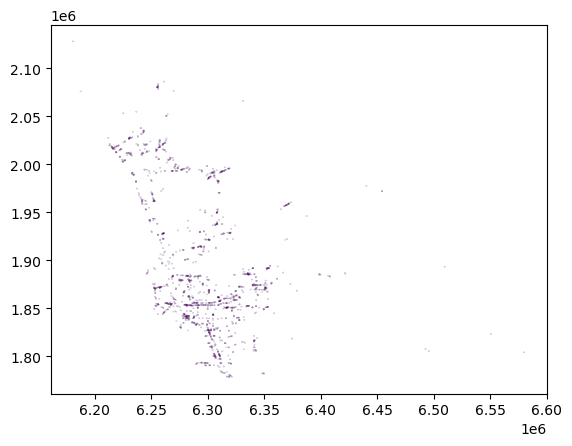

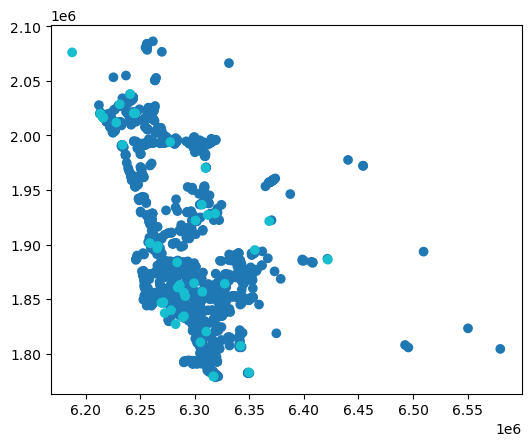

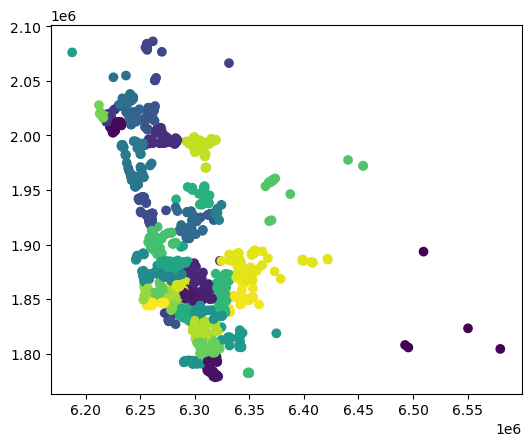

In [4]:
clustering(gdf[gdf['BUSTYPE']=='CAFE-FAST FOOD']).plot(column='cluster')